In [196]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pylab as plt

# load data
from sklearn.datasets import make_moons

all_features, all_targets = make_moons(n_samples=10000, noise=0.05)

In [534]:
def hierarchial_clustering(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    clustering.fit(data)
    labels = clustering.labels_
    return labels

def sample_points(a, size, return_indices=False):
    n = a.shape[0]
    idx = np.random.choice(np.arange(n), size=size, replace=False)
    x = a[idx, :]

    if return_indices:
        return idx, x
    return x

def representation_points(x, m, alpha):
    _, r = sample_points(x, size=m, return_indices=True)
    centroid = x.mean(axis=0)
    rr = r + alpha*(centroid - r)
    # x[idx, :] = rr
    return rr

def scatter(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], **kwargs)

def axscatter(ax, x, **kwargs):
    ax.scatter(x[:,0], x[:,1], **kwargs)

def split(features, target, n_clusters):
    return [features[target == i, :] for i in range(n_clusters)]

def plot_representation_points(x, label, n_clusters, R):
    x_groups = split(x, label, n_clusters)

    for i, d in enumerate(x_groups):    
        scatter(d)
        scatter(R[i])

    plt.title('Representation Points')
    plt.show()

def representation_matrix(X, n_clusters, m, sample_n, alpha=0.1, target=None, plot=False):
    '''
    returns: (n_clusters, m, d) matrix
    where m is number of representation points for each cluster
    and d is dimension of our points
    '''

    # cluster stochastic sampled data
    idx, x = sample_points(X, size=int(sample_n*X.shape[0]), return_indices=True)
    if target is None:
        print("Warning: CURE's hierarchial clustering is not implemented yet, switching back to sklearn's methods")
        label = hierarchial_clustering(x, n_clusters=n_clusters)
    else:
        label = target[idx]

    R = np.zeros((n_clusters, m, X.shape[1]))

    # group by label
    x_groups = split(x, label, n_clusters)

    for i, d in enumerate(x_groups):
        r = representation_points(d, m, alpha)
        R[i, :, :] = r

    if plot:
        plot_representation_points(x, label, n_clusters, R)

    return R

def plot_distance_fields(X, R, D):
    n_clusters, m = R.shape[0:2]
    fig, axs = plt.subplots(m+1, n_clusters, figsize=(12, 20))

    for j in range(n_clusters):
        for i, x in enumerate(split(X, all_targets, n_clusters)):
            axs[0,j].scatter(x[:,0], x[:,1])
        
    for i in range(n_clusters):
        axs[0,i].scatter(R[i, :, 0], R[i, :, 1])

    for cluster in range(n_clusters):
        for i in range(0, m):
            colors = D[cluster, i, :]
            axs[i+1,cluster].scatter(X[:,0], X[:,1], c=colors)
            r = R[cluster, i]
            axs[i+1,cluster].scatter(r[0], r[1], color='red' if cluster == 0 else 'blue')

    plt.suptitle('Distance Fields')
    plt.tight_layout()
    plt.show()

def distance_fields(X, R, plot=False):
    n_clusters, m = R.shape[0:2]
    D = np.zeros((n_clusters, m, X.shape[0]))

    for c in range(n_clusters):
        for i in range(m):
            d = X - R[c,i]
            D[c,i,:] = (d ** 2).sum(axis=1)

    if plot:
        plot_distance_fields(X, R, D)

    return D

def cluster_fit(X, D, m):
    Z = D.reshape((-1, X.shape[0]))
    clusters = Z.argmin(axis=0) // m
    return clusters

def CURE(X, n_clusters=2, m=10, sample_n=0.05, alpha=0.1, return_locals=True, target=None):
    if n_clusters > 2:
        raise Exception("Not implemented: need CURE cluster merge function")
    R = representation_matrix(X, n_clusters, m, sample_n, alpha, target=target, plot=False)
    D = distance_fields(X, R, plot=False)
    c = cluster_fit(X, D, m)
    
    return c if not return_locals else c, R, D

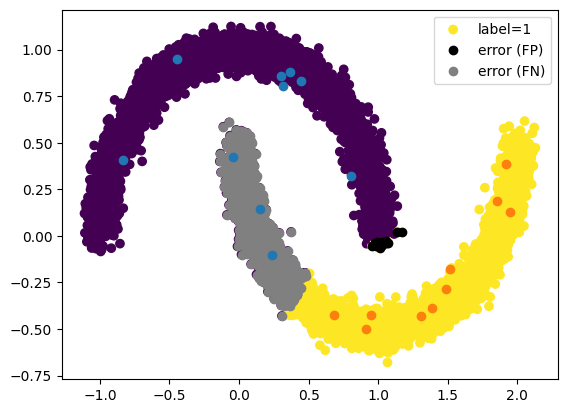

In [535]:
X, y = all_features, all_targets

# number of representation points for each cluster
m = 10
n_clusters = 2

c, R, _ = CURE(X, m=m, n_clusters=n_clusters, sample_n=0.5, alpha=0.1)
scatter(X, c=c, label='label=1')

scatter(X[y < c], color='black', label='error (FP)')
scatter(X[y > c], color='gray', label='error (FN)')

for i in range(n_clusters):
    scatter(R[i])

plt.legend()
plt.show()

##### (Hidden) Further experimentation

In [533]:
def _testing_cure_for_iterations():
    # Note: 
    
    X, y = all_features, all_targets
    target = None
    iterations = 10

    fig, axs = plt.subplots(iterations,1, figsize=(5,iterations*2))

    for i in range(iterations):
        c, l = CURE(X, target=c, return_locals=True)
        axscatter(axs[i], X, c=c, label='label=1')

        dif = c != y
        axscatter(axs[i], X[dif], color='pink', label='errors')

        for j in range(n_clusters):
            label = f'c{j} r.p'
            axscatter(axs[i], l['R'][j], label=label)

        # axs[i].title('Result Clusters')

    plt.legend(loc='upper right')
    fig.tight_layout()
    plt.show()